# Evaluation

## Importing libraries

In [39]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

random_state = 1
np.random.seed(random_state)

## Preparing the dataset

In [2]:
df = pd.read_csv('bank-full.csv', sep=";")
df = df[['age', 'job', 'marital', 'education', 'balance', 
         'housing', 'contact', 'day', 'month', 'duration', 
         'campaign', 'pdays', 'previous', 'poutcome', 'y']]
print(f'{(df.isnull().sum() > 0).sum()} columns in the dataset have missing values')

y = df['y'].map({'yes': 1, 'no': 0})
x = df.drop('y', axis=1)

train_data, temp_data = train_test_split(x, test_size=0.4, random_state=random_state)
y_train = y[train_data.index]
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=random_state)
y_val = y[val_data.index]
y_test = y[test_data.index]

0 columns in the dataset have missing values


## Question 1: ROC AUC feature importance

In [3]:
numerical = df.select_dtypes(include='number').columns.values
numerical

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous'], dtype=object)

In [4]:
max_auc = 0
variable_name = ''
for col in numerical:
    auc_score = roc_auc_score(y_train, train_data[col])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -train_data[col])
    if auc_score > max_auc:
        variable_name = col
        max_auc = auc_score
    # print(f"Variable '{col}' has {round(auc_score, 2)} AUC")

f"'{variable_name}' has the highest AUC {round(max_auc, 2)}"


"'duration' has the highest AUC 0.81"

## Question 2: Training the model

In [9]:
def prepare_train(train_data):  
    train_dict = train_data.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    return X_train, dv

def train_model(X_train, y_train, C):
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=random_state)
    model.fit(X_train, y_train)
    return model

def prepare_val(val_data, dv):
    val_dict = val_data.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    return X_val

In [11]:
X_train, dv = prepare_train(train_data)
X_val = prepare_val(val_data, dv)
model = train_model(X_train, y_train, 1.0)
y_pred = model.predict(X_val)
f"AUC is {round(roc_auc_score(y_val, y_pred), 3)} on the validation dataset"

'AUC is 0.659 on the validation dataset'

## Question 3: Precision and Recall

In [21]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.00712118, 0.03458869, 0.03809236, ..., 0.08733983, 0.12564696,
       0.00386254])

In [36]:
thresholds = np.arange(0, 1, 0.01)
scores = []

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * (p*r/(p+r))
    scores.append((t, tp, fp, fn, tn, p, r, f1))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r', 'f1']
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r,f1
0,0.0,1028,8014,0,0,0.113692,1.000000,0.204171
10,0.1,872,1498,156,6516,0.367932,0.848249,0.513243
20,0.2,698,685,330,7329,0.504700,0.678988,0.579013
30,0.3,560,438,468,7576,0.561122,0.544747,0.552813
40,0.4,457,292,571,7722,0.610147,0.444553,0.514350
50,0.5,353,205,675,7809,0.632616,0.343385,0.445145
60,0.6,283,145,745,7869,0.661215,0.275292,0.388736
70,0.7,217,111,811,7903,0.661585,0.211089,0.320059
80,0.8,137,73,891,7941,0.652381,0.133268,0.221325
90,0.9,69,38,959,7976,0.644860,0.067121,0.121586


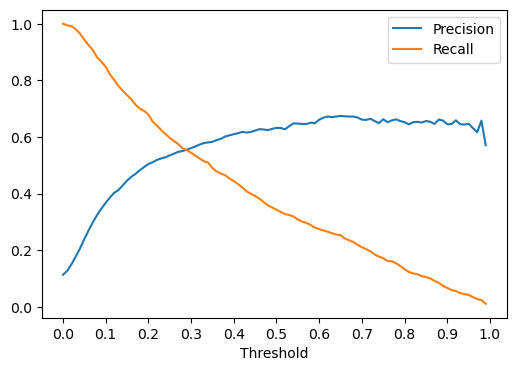

In [34]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, df_scores.p, label='Precision')
plt.plot(thresholds, df_scores.r, label='Recall')
plt.legend()
plt.xlabel('Threshold')
plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Question 4: F1 score

In [38]:
df_scores.loc[df_scores['f1'].idxmax()]['threshold']

0.2

## Question 5: 5-Fold CV

In [55]:
def get_aucs(df_train_full, C):
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    aucs = []
    
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        y_train = y[df_train.index]
    
        df_val = df_train_full.iloc[val_idx]
        y_val = y[df_val.index]
    
        X_train, dv = prepare_train(df_train)
        X_val = prepare_val(df_val, dv)
        model = train_model(X_train, y_train, C)
        y_pred = model.predict(X_val)
    
        rocauc = roc_auc_score(y_val, y_pred)
        aucs.append(rocauc)
    return aucs

In [56]:
df_train_full = pd.concat([train_data , val_data])
get_aucs(df_train_full, 1.0)

[0.6469073277494207,
 0.6510032256150247,
 0.6712704039662409,
 0.6703068102387849,
 0.6585780885780886]

In [57]:
f"Standard deviation of the scores across different folds is {round(np.array(aucs).std(),4)}"

'Standard deviation of the scores across different folds is 0.0099'

## Question 6: Hyperparameter Tuning

In [58]:
for C in [0.000001, 0.001, 1]:
    aucs = get_aucs(df_train_full, C)
    print(f"C={C}, auc = {round(np.mean(aucs), 3)} ± {round(np.std(aucs), 3)}"

aucs

SyntaxError: '(' was never closed (1225648788.py, line 3)